## main begins

In [1]:
from sentiment import *
import classify

In [2]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname)
print("\nTraining classifier")

cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels

Training classifier

Evaluating
  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8275109170305677


0.8275109170305677

In [398]:
print(len(sentiment.count_vect.vocabulary_))
print(len(sentiment.count_vect.idf_))
print(cls.coef_.shape)

175067
175067
(1, 175067)


## bind tokens with idf and classifer weights

In [399]:
import operator
sorted(zip(sentiment.count_vect.get_feature_names(), sentiment.count_vect.idf_),
       key=operator.itemgetter(1))[::-1][:10]
idf_dict = dict(zip(sentiment.count_vect.get_feature_names(), sentiment.count_vect.idf_))

In [400]:
coef_dict = dict(zip(sentiment.count_vect.get_feature_names(), cls.coef_.ravel()))

## frequencies of positive and negative reviews

4582
4582
# positive reviews: 2291
# negative reviews: 2291


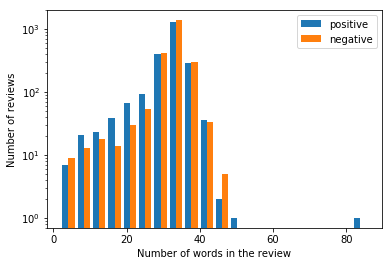

In [401]:
from collections import Counter
import matplotlib.pyplot as plt
print(len(sentiment.train_data_corr))
print(len(sentiment.train_data))
sentence_length = [len(l) for l in sentiment.train_data_corr]

# sentence length histograms
"""
seems that negative reviews are longer
"""
sentence_length_pos = [len(l) for t, l in zip(sentiment.trainy, sentiment.train_data_corr) if t == 1]
print('# positive reviews: %i' % len(sentence_length_pos))
sentence_length_neg = [len(l) for t, l in zip(sentiment.trainy, sentiment.train_data_corr) if t == 0]
print('# negative reviews: %i' % len(sentence_length_neg))
plt.hist((sentence_length_pos, sentence_length_neg), bins=20,
         label=['positive', 'negative'])
plt.yscale('log')
plt.legend()
plt.xlabel('Number of words in the review')
plt.ylabel('Number of reviews')
plt.show()

## most weighted tokens and their rareness

In [402]:
token_flat = [token for sent in sentiment.count_vect.inverse_transform(sentiment.trainX) for token in sent]

In [403]:
c = Counter(token_flat)
common_tokens, _ = zip(*c.most_common(100))
# for t in common_tokens:
#     print(t, idf_dict[t], coef_dict[t])
common_tokens = [token for token, count in c.most_common() if count>10]
common_tokens_idf = [idf_dict[t] for t in common_tokens]
common_tokens_coef = [coef_dict[t] for t in common_tokens]

('worst', 'horrible', 'great', 'amazing', 'delicious', 'excellent', 'terrible', 'best', 'rude', 'not', 'the worst', 'awesome', 'disappointing', 'love', 'the best', 'disappointed', 'closed', 'bad', 'average', 'overpriced', '!', 'wonderful', 'perfect', 'poor', 'fantastic', 'awful', 'meh', 'friendly', 'slow', 'dirty')


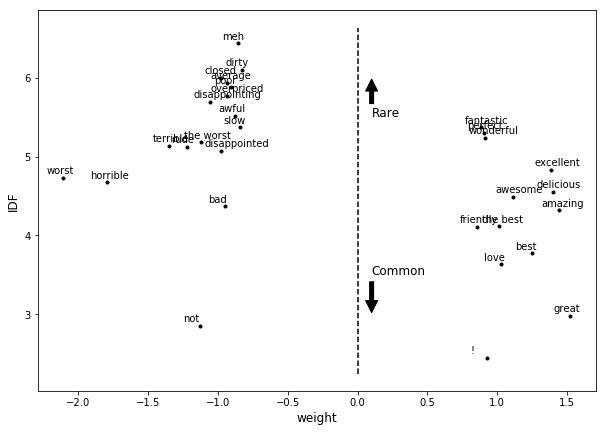

In [404]:
%matplotlib inline
#notebook
common_tokens_weight = [(t, idf_dict[t] * coef_dict[t]) for t in common_tokens]
top_weighted_tokens = sorted(common_tokens_weight, key=lambda x: abs(x[1]))[::-1][:30]
top_tokens, weights = zip(*top_weighted_tokens)
print(top_tokens)
x = weights
y = [idf_dict[t] for t in top_tokens] #[coef_dict[t] for t in top_tokens]

plt.figure(figsize=(10,7))
plt.plot(x, y , 'k.')
plt.plot([0,0], plt.ylim(), 'k--')
for i, t in enumerate(top_tokens):
    anchor = (x[i]-0.12, y[i]+0.05)
#     if t == 'rude':
#         anchor = (anchor[0]+0.1, anchor[1]-0.15)
#     if t == 'disappointed':
#         anchor = (anchor[0]+0.1, anchor[1]-0.2)
#     if t == 'disappointing':
#         anchor = (anchor[0]+0.1, anchor[1]-0.2)
#     if t == 'average':
#         anchor = (anchor[0]+0.15, anchor[1]-0.05)
    plt.annotate(t, anchor)
    
plt.xlabel('weight', fontsize=12)
plt.ylabel('IDF', fontsize=12)
plt.annotate('Rare', xy=(0.1, 6.0), xytext=(0.1, 5.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.annotate('Common', xy=(0.1, 3.0), xytext=(0.1, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.show()

# about confidence (probability of prediction)

In [313]:
probs = np.max(cls.predict_proba(sentiment.devX), axis=1)
print(len(probs))

458


## the most confident but incorrect example

I went in for an umbrella for our umbrella stroller but they didn't have it.  However, I had three of the nicest employees helping me out which I greatly 1 0
sum of weights:  -6.555607246915639
[0.9982831 0.0017169]


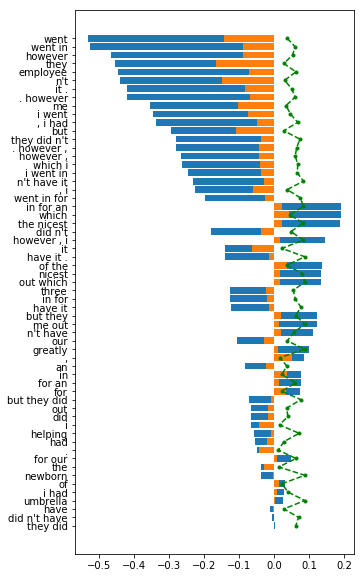

In [384]:
ind_prob = list(enumerate(probs))
targets = sentiment.devy
preds = cls.predict(sentiment.devX)
false_inds = np.argwhere(targets != preds).ravel()
ind_, _ = sorted(zip(false_inds, probs[false_inds]),
                 key=operator.itemgetter(1))[::-1][0]
print(sentiment.dev_data[ind_], targets[ind_], preds[ind_])

token_weight = sorted([(token, idf_dict[token]*coef_dict[token]) for token in sentiment.count_vect.inverse_transform(sentiment.devX[ind_])[0]], key=lambda x: abs(x[1]))[::-1]
# print(token_weight)

tokens, weights = zip(*token_weight)
print('sum of weights: ', sum(weights))
print(cls.predict_proba(sentiment.devX[ind_])[0])

plt.figure(figsize=(5,10))
plt.barh(y=range(len(weights))[::-1], width=weights, 
         tick_label=tokens)
plt.barh(y=range(len(weights))[::-1], width=[coef_dict[token] for token in tokens])
plt.plot([idf_dict[token]/100 for token in tokens], range(len(weights))[::-1], '.--', color='green')

## most confident examples

In [388]:
inds, _ = zip(*sorted(ind_prob, key=lambda x:x[1])[::-1][:5])

In [392]:
for i in inds:
    print(sentiment.dev_data[i],
          cls.predict(sentiment.devX[i]),
          sentiment.dev_labels[i], end='\n---\n')

The best mexican food! ! Cynthia was my server, and she was very friendly, and she recommended tampiqueña, and it was awesome, and chocolate tamal really good [1] POSITIVE
---
The worst experience ever they must have monkeys running this place sat in line for 20 minutes and did not move. I will not be using them ever you guys [0] NEGATIVE
---
This is the best Thai food Ive had in the States. The Tom Kha soup is on point, the perfect balance of savory and sweet. I had amazing curry and [1] POSITIVE
---
Valle Luna has the best mexican food around.  Since the Ahwatukee location we drive to Chandler. Service is fast and the food is awesome. Great Happy too! [1] POSITIVE
---
I love this place. They have great breakfast treats and great lunches not to mention the amazing sweets!! Also they have homemade icecream with moose tracks. YUM I like to [1] POSITIVE
---


## least confidence examples

In [395]:
inds, _ = zip(*sorted(ind_prob, key=lambda x:x[1])[:5])
for i in inds:
    print(sentiment.dev_data[i],
          cls.predict(sentiment.devX[i]),
          sentiment.dev_labels[i], end='\n---\n')
"""
Mostly contains 'but' or other adversatives. indicates a turn in meaning
use LIME to analyze these examples to show more
"""

It's Apple people. Busy, smells like sweat, expensive gadgets and electronics. But I love my iPhone, iPad  and Mac. [0] POSITIVE
---
I went to Von's only to get a gallon of milk.  I detest this store.  Oh, it's clean and the employees are friendly.  But they have nothing [0] NEGATIVE
---
It's customary to wait 45 minutes for a table here on the weekends. The unusual part is that I wait joyously and eager for a table the entire wait. I [1] POSITIVE
---
Been here a handful of times, I usually bring my church toga, which is a very important piece of thread to me. So if anything happened to it, I'd be [0] POSITIVE
---
Phenomenal!  Came back here to celebrate a birthday and everything was what I expected and more.  My requests for a particular table were all handled without any problems. [1] POSITIVE
---


"\nMostly contains 'but' or other adversatives. indicates a turn in meaning\nuse LIME to analyze these examples to show more\n"

## how performance relates to confidence

In [275]:
bin_bound = np.linspace(0.5, 1, 10)
bin_x = (bin_bound[:-1] + bin_bound[1:])/2
digits = np.digitize(probs, bin_bound)
from collections import defaultdict
bin_inds = defaultdict(list)
for i, i_bin in enumerate(digits):
    bin_inds[i_bin].append(i)

from sklearn.metrics import precision_score, recall_score
def precision_recall(targets, preds):
    precision = precision_score(targets, preds)
    assert(precision == sum((preds == targets) * preds) / sum(preds))
    recall = recall_score(targets, preds)
    assert(recall == sum((preds == targets) * preds) / sum(targets))
    return precision, recall

In [291]:
stats = []
for i_bin in bin_inds:
    targets = sentiment.devy[bin_inds[i_bin]]
    preds = cls.predict(sentiment.devX[bin_inds[i_bin]])
    stats.append((bin_x[i_bin-1],
                  len(bin_inds[i_bin]),
                  precision_recall(targets, preds)))

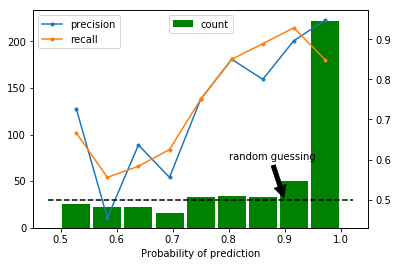

'\nweird behaviour around 0.5 bin\n'

In [312]:
bin_x_, count, p_r = zip(*sorted(stats))
precision, recall = zip(*p_r)
assert np.all(bin_x == bin_x_)
fig, ax = plt.subplots()
ax.bar(x=bin_x, height=count, width=0.05, color='green',
       label='count')
ax1 = ax.twinx()
ax1.plot(bin_x, precision, '.-', label='precision')
ax1.plot(bin_x, recall, '.-', label='recall')
ax1.legend()
ax.legend(loc='upper center')
ax.set_xlabel('Probability of prediction')
ax1.plot(ax1.get_xlim(), [0.5, 0.5], 'k--')
ax1.annotate('random guessing',
             xy=(0.9, 0.5), xytext=(0.8, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
"""
weird behaviour around 0.5 bin
"""

In [299]:
precision_recall(sentiment.trainy,
                 np.random.choice([0,1], len(sentiment.trainy)))

(0.5017574692442882, 0.4984722828459188)